In [110]:
import sqlite3
import pandas as pd
from random import sample
import matplotlib.pyplot as plt
import numpy as np
from scipy.stats import norm
import datetime 

In [2]:
conn = sqlite3.connect('../data/trip_data.db')

In [3]:
q_license = """
SELECT distinct(hack_license) as UNIQ_LIC
FROM trip
"""

unique_license = pd.read_sql(q_license, conn)

In [4]:
LIC_SAMPLE_NUM = 5000
sampled_drivers = sample(unique_license.UNIQ_LIC.tolist(), LIC_SAMPLE_NUM)

In [5]:
q_sample = """
SELECT *, 
        lag(pickup_datetime, -1, NULL) over (partition by hack_license order by pickup_datetime) as pickup_datetime_next,
        lag(dropoff_datetime, -1, NULL) over (partition by hack_license order by pickup_datetime) as dropoff_datetime_next
    FROM trip
    WHERE hack_license in {0}
ORDER BY hack_license ASC, pickup_datetime ASC, dropoff_datetime ASC
"""

sampled_trip = pd.read_sql(q_sample.format(tuple(sampled_drivers)), conn)

In [6]:
sampled_trip.head()

,medallion,hack_license,vendor_id,rate_code,pickup_datetime,dropoff_datetime,passenger_count,trip_time_in_secs,trip_distance,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,pickup_datetime_next,dropoff_datetime_next
0,2013000006,2013000006,VTS,2,2013-06-01 16:35:00,2013-06-01 17:21:00,6,2760,17.12,-73.790619,40.645306,-73.986618,40.737881,2013-06-01 17:26:00,2013-06-01 17:41:00
1,2013000006,2013000006,VTS,1,2013-06-01 17:26:00,2013-06-01 17:41:00,6,900,5.52,-73.975159,40.741516,-74.009254,40.713387,2013-06-01 17:44:00,2013-06-01 17:51:00
2,2013000006,2013000006,VTS,1,2013-06-01 17:44:00,2013-06-01 17:51:00,6,420,2.08,-74.005173,40.720913,-73.987198,40.742088,2013-06-01 17:53:00,2013-06-01 17:58:00
3,2013000006,2013000006,VTS,1,2013-06-01 17:53:00,2013-06-01 17:58:00,6,300,0.91,-73.985703,40.743813,-73.985268,40.753422,2013-06-01 17:59:00,2013-06-01 18:02:00
4,2013000006,2013000006,VTS,1,2013-06-01 17:59:00,2013-06-01 18:02:00,6,180,0.49,-73.985001,40.753681,-73.979195,40.756042,2013-06-01 18:03:00,2013-06-01 18:16:00


In [7]:
date_cols = ['pickup_datetime', 'dropoff_datetime', 'pickup_datetime_next', 'dropoff_datetime_next']

for c in date_cols:
    sampled_trip[c] = pd.to_datetime(sampled_trip[c])
sampled_trip['delta'] = (sampled_trip['pickup_datetime_next'] - sampled_trip['dropoff_datetime']) / pd.Timedelta(hours=1)

In [8]:
k=5

## If delta > k, the trip is the last drop off of the shift
## And the next trip of the driver is the first pickup (shifted)
sampled_trip['last_dropoff'] = [1 if d > k else 0 for d in sampled_trip['delta']]
sampled_trip['first_pickup'] = sampled_trip.groupby('hack_license')['last_dropoff'].shift(1)
sampled_trip.dropna(subset=['pickup_datetime_next', 'dropoff_datetime_next'], inplace=True) 
sampled_trip['first_pickup'].fillna(0, inplace=True)

In [9]:
sampled_trip.head()

,medallion,hack_license,vendor_id,rate_code,pickup_datetime,dropoff_datetime,passenger_count,trip_time_in_secs,trip_distance,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,pickup_datetime_next,dropoff_datetime_next,delta,last_dropoff,first_pickup
0,2013000006,2013000006,VTS,2,2013-06-01 16:35:00,2013-06-01 17:21:00,6,2760,17.12,-73.790619,40.645306,-73.986618,40.737881,2013-06-01 17:26:00,2013-06-01 17:41:00,0.083333,0,0.0
1,2013000006,2013000006,VTS,1,2013-06-01 17:26:00,2013-06-01 17:41:00,6,900,5.52,-73.975159,40.741516,-74.009254,40.713387,2013-06-01 17:44:00,2013-06-01 17:51:00,0.050000,0,0.0
2,2013000006,2013000006,VTS,1,2013-06-01 17:44:00,2013-06-01 17:51:00,6,420,2.08,-74.005173,40.720913,-73.987198,40.742088,2013-06-01 17:53:00,2013-06-01 17:58:00,0.033333,0,0.0
3,2013000006,2013000006,VTS,1,2013-06-01 17:53:00,2013-06-01 17:58:00,6,300,0.91,-73.985703,40.743813,-73.985268,40.753422,2013-06-01 17:59:00,2013-06-01 18:02:00,0.016667,0,0.0
4,2013000006,2013000006,VTS,1,2013-06-01 17:59:00,2013-06-01 18:02:00,6,180,0.49,-73.985001,40.753681,-73.979195,40.756042,2013-06-01 18:03:00,2013-06-01 18:16:00,0.016667,0,0.0


In [10]:
## Extract hour and day
sampled_trip['dropoff_hour'] = sampled_trip.dropoff_datetime.dt.hour
sampled_trip['pickup_hour'] = sampled_trip.pickup_datetime.dt.hour
sampled_trip['dropoff_day'] = sampled_trip.dropoff_datetime.dt.date
sampled_trip['pickup_day'] = sampled_trip.pickup_datetime.dt.date
sampled_trip['pickup_weekday'] = (sampled_trip.loc[:,'pickup_datetime'].dt.dayofweek // 5 == 0).astype(int)
sampled_trip['dropoff_weekday'] = (sampled_trip.loc[:,'dropoff_datetime'].dt.dayofweek // 5 == 0).astype(int)


In [11]:
sampled_trip.head()

,medallion,hack_license,vendor_id,rate_code,pickup_datetime,dropoff_datetime,passenger_count,trip_time_in_secs,trip_distance,pickup_longitude,...,dropoff_datetime_next,delta,last_dropoff,first_pickup,dropoff_hour,pickup_hour,dropoff_day,pickup_day,pickup_weekday,dropoff_weekday
0,2013000006,2013000006,VTS,2,2013-06-01 16:35:00,2013-06-01 17:21:00,6,2760,17.12,-73.790619,...,2013-06-01 17:41:00,0.083333,0,0.0,17,16,2013-06-01,2013-06-01,0,0
1,2013000006,2013000006,VTS,1,2013-06-01 17:26:00,2013-06-01 17:41:00,6,900,5.52,-73.975159,...,2013-06-01 17:51:00,0.050000,0,0.0,17,17,2013-06-01,2013-06-01,0,0
2,2013000006,2013000006,VTS,1,2013-06-01 17:44:00,2013-06-01 17:51:00,6,420,2.08,-74.005173,...,2013-06-01 17:58:00,0.033333,0,0.0,17,17,2013-06-01,2013-06-01,0,0
3,2013000006,2013000006,VTS,1,2013-06-01 17:53:00,2013-06-01 17:58:00,6,300,0.91,-73.985703,...,2013-06-01 18:02:00,0.016667,0,0.0,17,17,2013-06-01,2013-06-01,0,0
4,2013000006,2013000006,VTS,1,2013-06-01 17:59:00,2013-06-01 18:02:00,6,180,0.49,-73.985001,...,2013-06-01 18:16:00,0.016667,0,0.0,18,17,2013-06-01,2013-06-01,0,0


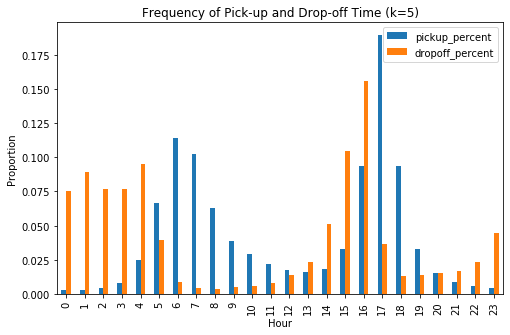

In [12]:
## Compute percentage

pickup_df = sampled_trip.loc[sampled_trip['first_pickup'] == 1]
pickup_per = pickup_df.groupby(['pickup_day', 'pickup_hour', 'pickup_weekday'])['pickup_hour'].count()
pickup_per = pickup_per.groupby('pickup_day').apply(lambda x: x / x.sum())
pickup_per = pd.DataFrame(pickup_per).rename(columns={'pickup_hour':'pickup_percent'}).reset_index().\
                                        rename(columns={'pickup_day':'date',
                                                        'pickup_hour':'hour',
                                                           'pickup_weekday': 'weekday'})

dropoff_df = sampled_trip.loc[sampled_trip['last_dropoff'] == 1]
dropoff_per = dropoff_df.groupby(['dropoff_day', 'dropoff_hour', 'dropoff_weekday'])['dropoff_hour'].count()
dropoff_per = dropoff_per.groupby('dropoff_day').apply(lambda x: x / x.sum())
dropoff_per = pd.DataFrame(dropoff_per).rename(columns={'dropoff_hour':'dropoff_percent'}).reset_index().\
                                        rename(columns={'dropoff_day':'date',
                                                        'dropoff_hour':'hour',
                                                           'dropoff_weekday': 'weekday'})

pick_drop_per = pickup_per.merge(dropoff_per)
pick_drop_per.head()


# % of Pick-up and Drop-off Time
pick_drop_per_all = pick_drop_per.groupby(['hour'])['pickup_percent','dropoff_percent'].mean().\
                                reset_index().set_index('hour')

fig,ax = plt.subplots(figsize = (8,5))
pick_drop_per_all.plot(kind='bar',ax=ax);
ax.set_xlabel('Hour');
ax.set_ylabel('Proportion');
ax.set_title('Frequency of Pick-up and Drop-off Time (k={})'.format(k));
ax.legend();

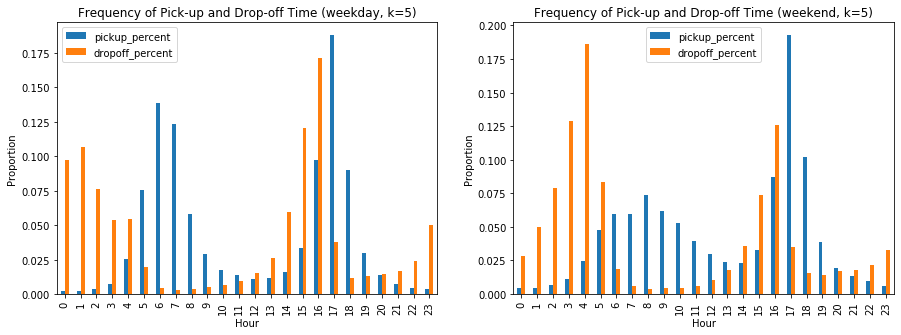

In [13]:
# Frequency of Pick-up and Drop-off Time (weekday and weekend)
pick_drop_per_wk = pick_drop_per.groupby(['hour','weekday'])['pickup_percent','dropoff_percent'].mean().\
                                reset_index().set_index('hour')

fig,ax = plt.subplots(1,2,figsize = (15,5))
pick_drop_per_wk[pick_drop_per_wk.weekday == 1].drop('weekday',axis=1).plot(kind='bar',ax=ax[0]);
pick_drop_per_wk[pick_drop_per_wk.weekday == 0].drop('weekday',axis=1).plot(kind='bar',ax=ax[1]);
ax[0].set_xlabel('Hour');
ax[0].set_ylabel('Proportion');
ax[0].set_title('Frequency of Pick-up and Drop-off Time (weekday, k={})'.format(k));
ax[0].legend();

ax[1].set_xlabel('Hour');
ax[1].set_ylabel('Proportion');
ax[1].set_title('Frequency of Pick-up and Drop-off Time (weekend, k={})'.format(k));
ax[1].legend()

## Sample start and end times

In [81]:
sampled_trip.head()

,medallion,hack_license,vendor_id,rate_code,pickup_datetime,dropoff_datetime,passenger_count,trip_time_in_secs,trip_distance,pickup_longitude,...,dropoff_datetime_next,delta,last_dropoff,first_pickup,dropoff_hour,pickup_hour,dropoff_day,pickup_day,pickup_weekday,dropoff_weekday
0,2013000006,2013000006,VTS,2,2013-06-01 16:35:00,2013-06-01 17:21:00,6,2760,17.12,-73.790619,...,2013-06-01 17:41:00,0.083333,0,0.0,17,16,2013-06-01,2013-06-01,0,0
1,2013000006,2013000006,VTS,1,2013-06-01 17:26:00,2013-06-01 17:41:00,6,900,5.52,-73.975159,...,2013-06-01 17:51:00,0.050000,0,0.0,17,17,2013-06-01,2013-06-01,0,0
2,2013000006,2013000006,VTS,1,2013-06-01 17:44:00,2013-06-01 17:51:00,6,420,2.08,-74.005173,...,2013-06-01 17:58:00,0.033333,0,0.0,17,17,2013-06-01,2013-06-01,0,0
3,2013000006,2013000006,VTS,1,2013-06-01 17:53:00,2013-06-01 17:58:00,6,300,0.91,-73.985703,...,2013-06-01 18:02:00,0.016667,0,0.0,17,17,2013-06-01,2013-06-01,0,0
4,2013000006,2013000006,VTS,1,2013-06-01 17:59:00,2013-06-01 18:02:00,6,180,0.49,-73.985001,...,2013-06-01 18:16:00,0.016667,0,0.0,18,17,2013-06-01,2013-06-01,0,0


In [179]:
def get_shift(time, weekday=True, pickup=True):
    if weekday:
        if pickup:
            if (time > datetime.time(23, 30)) | (time <= datetime.time(11, 30)):
                return 'A'
            else:
                return 'B'
        else:
            if (time > datetime.time(8, 30)) & (time <= datetime.time(20, 30)):
                return 'A'
            else:
                return 'B'            
    else:
        return None

In [180]:
first_last_trip = sampled_trip.loc[(sampled_trip['first_pickup'] == 1) |
                                     (sampled_trip['last_dropoff'] == 1)]

first_last_trip.loc[:,'PU_time'] = first_last_trip['pickup_datetime'].apply(lambda x: x.time())
first_last_trip.loc[:,'DO_time'] = first_last_trip['dropoff_datetime'].apply(lambda x: x.time())



first_last_trip.loc[(first_last_trip['pickup_weekday']==1) &
                      (first_last_trip['first_pickup']==1) , '_PU_shift'] = first_last_trip.PU_time\
                                .apply(lambda x: get_shift(x, weekday=True, pickup=True))
first_last_trip.loc[(first_last_trip['pickup_weekday']==1) &
                      (first_last_trip['last_dropoff']==1), '_DO_shift'] = first_last_trip.DO_time\
                                .apply(lambda x: get_shift(x, weekday=True, pickup=False))

//anaconda3/lib/python3.7/site-packages/pandas/core/indexing.py:376: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.obj[key] = _infer_fill_value(value)
//anaconda3/lib/python3.7/site-packages/pandas/core/indexing.py:494: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.obj[item] = s


In [181]:
first_last_trip[['pickup_weekday', 'first_pickup', 'last_dropoff', 'PU_time', 'DO_time', '_PU_shift', '_DO_shift']]

,pickup_weekday,first_pickup,last_dropoff,PU_time,DO_time,_PU_shift,_DO_shift
41,0,0.0,1,04:38:00,04:52:00,NaN,NaN
42,0,1.0,0,17:35:00,17:47:00,NaN,NaN
65,1,0.0,1,04:11:00,04:19:00,NaN,B
66,1,1.0,0,17:09:00,17:14:00,B,NaN
99,1,0.0,1,04:12:00,04:23:00,NaN,B
...,...,...,...,...,...,...,...
2172526,0,1.0,0,06:58:13,07:05:45,NaN,NaN
2172576,0,0.0,1,18:07:00,18:09:00,NaN,NaN
2172577,0,1.0,0,07:45:00,07:51:00,NaN,NaN
2172623,0,0.0,1,02:29:51,02:45:07,NaN,NaN


In [203]:
def sample_start_end_time(first_last_trip_df):
    random_shift = np.random.choice(['A', 'B'], size=1, p = [i for i in shift_prob.values()])[0]
    # travel_time = datetime.timedelta(minutes=10)
#     print("random_shift: {}".format(random_shift))
    sampled_PU_time = first_last_trip_df.loc[first_last_trip_df['_PU_shift'] == random_shift]['PU_time'].sample().values[0]

    if random_shift == 'A':
        try:
            sampled_DO_time = first_last_trip_df.loc[(first_last_trip_df['_DO_shift'] == random_shift) &
                                                    (first_last_trip_df['DO_time'] > sampled_PU_time)]['DO_time'].sample().values[0]
#         print("-", sampled_DO_time)#
        except:
            print(sampled_PU_time)
            print(first_last_trip_df.loc[(first_last_trip_df['_DO_shift'] == random_shift) &
                                                    (first_last_trip_df['DO_time'] > sampled_PU_time)].shape)
            return None, None
    else: #shift B dropoff
        try:
            sampled_DO_time = first_last_trip_df.loc[(first_last_trip_df['_DO_shift'] == random_shift) &
                                                ((first_last_trip_df['DO_time'] > sampled_PU_time) |
                                                 (first_last_trip_df['DO_time'] <= datetime.time(8,30)))]['DO_time'].sample().values[0]
        except:
            return None, None
            #         print("-", sampled_DO_time) #.sample().values[0])
#     print("--Sampled PU time>> {}".format(sampled_PU_time))
#     print("--Sampled DO time>> {}".format(sampled_DO_time))
    
    return sampled_PU_time, sampled_DO_time

In [198]:
p_list = []
d_list = []
for t in range(100):
    pu,do = sample_start_end_time(first_last_trip.loc[first_last_trip['pickup_weekday'] == 1])
    p_list.append(pu)
    d_list.append(do)


AttributeError: module 'pandas' has no attribute 'DataDrame'

In [217]:
def find_time_diff(original_do_time, original_pu_time):
    
    pu_time = datetime.datetime.combine(datetime.datetime(1,1,1,0,0,0), original_pu_time)
    if original_do_time < original_pu_time:
        do_time = datetime.datetime.combine(datetime.datetime(1,1,2,0,0,0), original_do_time)
    else:
        do_time = datetime.datetime.combine(datetime.datetime(1,1,1,0,0,0), original_do_time)
    return (do_time - pu_time)/3600
#     datetime.datetime.combine(datetime.datetime(1,1,1,0,0,0), d_list[0]) - datetime.datetime.combine(datetime.datetime(1,1,1,0,0,0), p_list[0])

In [218]:
find_time_diff(p_list[0], d_list[0])

datetime.timedelta(seconds=13, microseconds=745000)

In [204]:
sampled_data = pd.DataFrame({'PU': p_list, 'DO': d_list})
# sampled_data['PU'] = pd.to_datetime(sampled_data['PU'])
# sampled_data['DO'] = pd.to_datetime(sampled_data['DO'])

sampled_data.loc[:,sampled_data['active_time']] = sampled_data['PU'] - sampled_data['DO']

TypeError: unsupported operand type(s) for -: 'datetime.time' and 'datetime.time'

In [ ]:
sampled_data

In [63]:
num_shift_A_wkday = pickup_df.loc[(pickup_df['pickup_weekday'] == 1) & 
                                  (pickup_df['PU_time'] >= datetime.time(2,0)) & 
                                  (pickup_df['PU_time'] <= datetime.time(10,0))].shape[0]

num_shift_B_wkday = pickup_df.loc[(pickup_df['pickup_weekday'] == 1) & 
                                  (pickup_df['PU_time'] >= datetime.time(13,0)) & 
                                  (pickup_df['PU_time'] <= datetime.time(21,0))].shape[0]

shift_prob = {'A': num_shift_A_wkday / (num_shift_A_wkday + num_shift_B_wkday), 
              'B': num_shift_B_wkday / (num_shift_A_wkday + num_shift_B_wkday)}

print('Prob shift A: {}'.format(shift_prob['A']))
print('Prob shift B: {}'.format(shift_prob['B']))


# pickup_df.loc[:, pickup_df['shift']] = 'A' if (pu_time >= datetime.time(2,0)) & ()

[0.4903760688999908, 0.5096239311000091]

In [18]:
## Shift break point for PU is A 2am-10am and B 1pm-9pm 
## Shift break point for DO is B 10pm-5am and A 12pm-8pm
wkday_A_pu = pickup_df.loc[(pickup_df['pickup_weekday'] == 1) & 
                            (pickup_df['pickup_hour'] >= 2) & 
                              (pickup_df['pickup_hour'] <=10)]
wkday_A_do = dropoff_df.loc[(dropoff_df['dropoff_weekday'] == 1) & 
                              (dropoff_df['dropoff_hour'] >= 12) & 
                            (dropoff_df['dropoff_hour'] <= 20)]


wkday_B_pu = pickup_df.loc[(pickup_df['pickup_weekday'] == 1) & 
                              (pickup_df['pickup_hour'] >=13) &
                            (pickup_df['pickup_hour'] <=21)]

wkday_B_do = dropoff_df.loc[(dropoff_df['dropoff_weekday'] == 1) & 
                              ((dropoff_df['dropoff_hour'] >= 22) | 
                            (dropoff_df['dropoff_hour'] <= 5))]
# wkday_B_do['dropoff_hour'] = [i-24 if i >= 22 else i for i in wkday_B_do['dropoff_hour']]


stat_dict = {'weekday': {'A': {'pickup': wkday_A_pu['pickup_hour'],
                               'dropoff': wkday_A_do['dropoff_hour']},
                         'B': {'pickup': wkday_B_pu['pickup_hour'],
                               'dropoff': wkday_B_do['dropoff_hour']}},
            'weekend': {'A': {'pickup': wkday_A_pu['pickup_hour'],
                              'dropoff': wkday_A_do['dropoff_hour']},
                        'B': {'pickup': wkday_B_pu['pickup_hour'],
                              'dropoff': wkday_B_do['dropoff_hour']}}}


In [ ]:
print(stat_dict['A']['pickup'].mean())
print(stat_dict['B']['pickup'].mean())

print(stat_dict['A']['pickup'].std())
print(stat_dict['B']['pickup'].std())


print(stat_dict['A']['dropoff'].mean())
print(stat_dict['B']['dropoff'].mean())

print(stat_dict['A']['dropoff'].std())
print(stat_dict['B']['dropoff'].std())

In [ ]:
# Frequency of Pick-up and Drop-off Time (weekday and weekend)
pick_drop_per_wk = pick_drop_per.groupby(['hour','weekday'])['pickup_percent','dropoff_percent'].mean().\
                                reset_index().set_index('hour')

fig,ax = plt.subplots(2,2,figsize = (15,10))
pick_drop_per_wk.loc[pick_drop_per_wk.weekday == 1]['pickup_percent'].plot(kind='bar',ax=ax[0,0]);
pick_drop_per_wk[pick_drop_per_wk.weekday == 1]['dropoff_percent'].plot(kind='bar',ax=ax[0,1]);
ax[0,0].set_xlabel('Hour');
ax[0,0].set_ylabel('Proportion');
ax[0,0].set_title('Frequency of Pick-up Time (weekday, k={})'.format(k));
ax[0,0].legend();
ax[0,1].set_title('Frequency of Drop-off Time (weekday, k={})'.format(k));
ax[0,1].legend();

pick_drop_per_wk.loc[pick_drop_per_wk.weekday == 0]['pickup_percent'].plot(kind='bar',ax=ax[1,0]);
pick_drop_per_wk[pick_drop_per_wk.weekday == 0]['dropoff_percent'].plot(kind='bar',ax=ax[1,1]);
ax[1,0].set_xlabel('Hour');
ax[1,0].set_ylabel('Proportion');
ax[1,0].set_title('Frequency of Pick-up Time (weekend, k={})'.format(k));
ax[1,0].legend();
ax[1,1].set_title('Frequency of Drop-off Time (weekend, k={})'.format(k));
ax[1,1].legend();


x_axis = np.arange(0, 23, 0.001)
ax[0,0].plot(x_axis, norm.pdf(x_axis,stat_dict['weekday']['A']['pickup'].mean(),stat_dict['weekday']['A']['pickup'].std()), color='blue')
ax[0,0].plot(x_axis, norm.pdf(x_axis,stat_dict['weekday']['B']['pickup'].mean(),stat_dict['weekday']['B']['pickup'].std()), color='red')

ax[0,1].plot(x_axis, norm.pdf(x_axis,stat_dict['weekday']['A']['dropoff'].mean(),stat_dict['weekday']['A']['dropoff'].std()), color='blue')
# ax[0,1].plot(x_axis, norm.pdf(B_dropoff_axis,stat_dict['B']['dropoff'].mean(),stat_dict['B']['dropoff'].std()), color='red')
ax[0,1].plot(x_axis, circle_pdf(x_axis, stat_dict['weekday']['B']['dropoff'].mean(),
                        stat_dict['weekday']['B']['dropoff'].std()), color='red')


ax[1,0].plot(x_axis, norm.pdf(x_axis,stat_dict['weekend']['A']['pickup'].mean(),stat_dict['A']['pickup'].std()), color='blue')
ax[1,0].plot(x_axis, norm.pdf(x_axis,stat_dict['B']['pickup'].mean(),stat_dict['B']['pickup'].std()), color='red')

ax[1,1].plot(x_axis, norm.pdf(x_axis,stat_dict['A']['dropoff'].mean(),stat_dict['A']['dropoff'].std()), color='blue')
# ax[0,1].plot(x_axis, norm.pdf(B_dropoff_axis,stat_dict['B']['dropoff'].mean(),stat_dict['B']['dropoff'].std()), color='red')
ax[1,1].plot(x_axis, circle_pdf(x_axis, stat_dict['B']['dropoff'].mean(),
                        stat_dict['B']['dropoff'].std()), color='red')

# ax[1].set_xlabel('Hour');
# ax[1].set_ylabel('Proportion');
# ax[1].set_title('Frequency of Pick-up and Drop-off Time (weekend, k={})'.format(k));
# ax[1].legend()

In [ ]:
## Wrap the hours around when considering hours that go over midnight
def circle_pdf(x_axis, mean, std):
    if (norm.pdf(0, mean, std) > 0.05) | (norm.pdf(23, mean, std) > 0.05):
        if norm.pdf(0, mean, std) > norm.pdf(23, mean, std):
            new_index = [i-23 if i > 16 else i for i in x_axis]
        else:
            new_index = [i+23 if i < 8 else i for i in x_axis]
    else:
        new_index = x_axis
    return [norm.pdf(i, mean, std) for i in new_index]

In [30]:
np.arange(-24, 47, 0.001)

def to_new_index(hours, center):
    return np.array([t + 11 - center for t in hours])

In [32]:
to_new_index(wkday_A_pu['pickup_hour'], 7).mean()

10.488196098531674

In [28]:
wkday_A_pu['pickup_hour'].tolist()

[10,
 10,
 5,
 9,
 9,
 7,
 7,
 9,
 5,
 8,
 8,
 7,
 5,
 5,
 5,
 5,
 6,
 5,
 5,
 5,
 5,
 5,
 5,
 5,
 5,
 5,
 4,
 6,
 5,
 4,
 4,
 5,
 5,
 5,
 5,
 5,
 4,
 5,
 5,
 6,
 6,
 6,
 4,
 7,
 7,
 7,
 8,
 9,
 9,
 6,
 6,
 7,
 7,
 6,
 7,
 6,
 7,
 7,
 6,
 8,
 6,
 6,
 7,
 6,
 7,
 6,
 8,
 5,
 4,
 5,
 5,
 5,
 10,
 6,
 10,
 5,
 7,
 8,
 8,
 9,
 8,
 9,
 10,
 8,
 8,
 8,
 8,
 8,
 8,
 9,
 8,
 8,
 9,
 8,
 9,
 10,
 5,
 2,
 6,
 5,
 5,
 5,
 6,
 8,
 9,
 7,
 7,
 8,
 10,
 5,
 3,
 7,
 8,
 6,
 6,
 6,
 6,
 5,
 6,
 6,
 5,
 6,
 6,
 7,
 7,
 6,
 6,
 4,
 4,
 5,
 5,
 6,
 4,
 4,
 5,
 5,
 6,
 6,
 4,
 5,
 5,
 6,
 6,
 7,
 6,
 6,
 5,
 6,
 6,
 6,
 6,
 5,
 7,
 6,
 6,
 6,
 7,
 6,
 6,
 6,
 5,
 6,
 6,
 5,
 6,
 6,
 6,
 6,
 6,
 6,
 6,
 6,
 4,
 5,
 6,
 8,
 8,
 10,
 7,
 8,
 7,
 5,
 7,
 5,
 6,
 6,
 8,
 5,
 6,
 7,
 7,
 2,
 7,
 7,
 7,
 7,
 7,
 6,
 7,
 7,
 7,
 8,
 6,
 8,
 7,
 7,
 7,
 7,
 7,
 7,
 7,
 7,
 7,
 8,
 9,
 4,
 9,
 6,
 9,
 6,
 6,
 6,
 6,
 6,
 5,
 6,
 6,
 6,
 6,
 6,
 6,
 5,
 10,
 10,
 10,
 10,
 8,
 8,
 8,
 9,
 10,
 8,
 8,
 10,
 8,
 9,
 1